# Sequential Game Recommendation:

This notebook implements the first two sections of the course project proposal:

1. **Identify the Predictive Task** – formalize the next-item prediction objective, build the required data splits, baselines, and evaluation metrics.
2. **Exploratory Analysis, Data Collection, Pre-processing** – load the raw Steam review data, clean/filter it, and construct ordered user sequences suitable for sequential modeling.


In [1]:
import os
import gzip
import ast
import json
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1200)

DATA_DIR = "/home/ubuntu/Projects/CSE258_assignment2/data"
REVIEWS_PATH = os.path.join(DATA_DIR, "steam_reviews.json.gz")

print(f"Data directory: {DATA_DIR}")


Data directory: /home/ubuntu/Projects/CSE258_assignment2/data


## Helper Functions


In [2]:
def load_reviews(path, max_records=None):
    """Parse the loose JSON (Python dict syntax) Steam reviews file into a DataFrame."""
    records = []
    with gzip.open(path, "rt", encoding="utf-8", errors="ignore") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            try:
                record = ast.literal_eval(line)
            except (ValueError, SyntaxError):
                # fallback: try json.loads after replacing single quotes
                try:
                    record = json.loads(line.replace("'", '"'))
                except json.JSONDecodeError:
                    continue
            records.append(record)
            if max_records and len(records) >= max_records:
                break
    df = pd.DataFrame(records)
    return df


def filter_interactions(df, min_user_reviews=5, min_item_reviews=5):
    """Filter out sparse users/items for better statistical stability."""
    user_counts = df['username'].value_counts()
    valid_users = user_counts[user_counts >= min_user_reviews].index
    df = df[df['username'].isin(valid_users)].copy()

    item_counts = df['product_id'].value_counts()
    valid_items = item_counts[item_counts >= min_item_reviews].index
    df = df[df['product_id'].isin(valid_items)].copy()

    return df


def build_sequences(df):
    """Sort interactions per user by time and build item sequences."""
    df = df.copy()
    if 'date' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'], errors='coerce')
    elif 'unixReviewTime' in df.columns:
        df['timestamp'] = pd.to_datetime(df['unixReviewTime'], unit='s', errors='coerce')
    else:
        raise ValueError("No recognizable timestamp column present.")

    df = df.dropna(subset=['timestamp'])
    df = df.sort_values(['username', 'timestamp'])

    sequences = df.groupby('username')['product_id'].apply(list)
    return sequences


def summarize_sequences(sequences):
    lengths = sequences.apply(len)
    summary = {
        'num_users': len(sequences),
        'num_interactions': lengths.sum(),
        'min_len': lengths.min(),
        'max_len': lengths.max(),
        'mean_len': lengths.mean(),
        'median_len': lengths.median()
    }
    return summary


In [3]:
def leave_one_out_split(sequences, min_length=3):
    """Return training histories, validation targets, and test targets per user."""
    train_histories = {}
    val_targets = {}
    test_targets = {}
    for user, seq in sequences.items():
        if len(seq) < min_length:
            continue
        train_histories[user] = seq[:-2]
        val_targets[user] = seq[-2]
        test_targets[user] = seq[-1]
    return train_histories, val_targets, test_targets


def hit_rate_at_k(rankings, ground_truth, k=10):
    hits = sum(1 for user, items in rankings.items() if ground_truth.get(user) in items[:k])
    total = len(ground_truth)
    return hits / total if total else 0.0


def ndcg_at_k(rankings, ground_truth, k=10):
    total = 0.0
    for user, items in rankings.items():
        gt = ground_truth.get(user)
        if gt in items[:k]:
            rank = items[:k].index(gt)
            total += 1.0 / np.log2(rank + 2)
    return total / len(ground_truth) if ground_truth else 0.0


In [4]:
class MostPopularRecommender:
    def __init__(self):
        self.ranked_items = []

    def fit(self, train_histories):
        counts = Counter()
        for seq in train_histories.values():
            counts.update(seq)
        self.ranked_items = [item for item, _ in counts.most_common()]
        return self

    def recommend(self, user, history, k=10, exclude_history=True):
        if not self.ranked_items:
            return []
        if not exclude_history:
            return self.ranked_items[:k]
        history_set = set(history)
        recs = [item for item in self.ranked_items if item not in history_set]
        return recs[:k]



In [5]:
class MarkovChainRecommender:
    def __init__(self):
        self.transitions = {}
        self.backup = None

    def fit(self, train_histories):
        trans_counts = defaultdict(Counter)
        for seq in train_histories.values():
            for prev_item, next_item in zip(seq[:-1], seq[1:]):
                trans_counts[prev_item][next_item] += 1
        self.transitions = {
            item: [idx for idx, _ in counts.most_common()]
            for item, counts in trans_counts.items()
        }
        self.backup = MostPopularRecommender().fit(train_histories)
        return self

    def recommend(self, user, history, k=10):
        if not history:
            return self.backup.recommend(user, history, k)
        last_item = history[-1]
        candidates = self.transitions.get(last_item)
        if not candidates:
            return self.backup.recommend(user, history, k)
        history_set = set(history)
        recs = [item for item in candidates if item not in history_set]
        if len(recs) < k:
            recs.extend(x for x in self.backup.ranked_items if x not in history_set and x not in recs)
        return recs[:k]



In [6]:
class ItemKNNRecommender:
    def __init__(self, top_neighbors=50):
        self.top_neighbors = top_neighbors
        self.similarity = defaultdict(Counter)
        self.pop_backup = None

    def fit(self, train_histories):
        from itertools import combinations

        co_counts = defaultdict(Counter)
        item_freq = Counter()

        for seq in train_histories.values():
            unique_items = set(seq)
            for item in unique_items:
                item_freq[item] += 1
            for a, b in combinations(sorted(unique_items), 2):
                co_counts[a][b] += 1
                co_counts[b][a] += 1

        for item, neighbors in co_counts.items():
            sims = {}
            for neighbor, count in neighbors.items():
                denom = item_freq[item] + item_freq[neighbor] - count
                if denom == 0:
                    continue
                sims[neighbor] = count / denom  # Jaccard similarity
            top = Counter(sims).most_common(self.top_neighbors)
            self.similarity[item] = Counter(dict(top))

        self.pop_backup = MostPopularRecommender().fit(train_histories)
        return self

    def recommend(self, user, history, k=10):
        if not history:
            return self.pop_backup.recommend(user, history, k)
        scores = Counter()
        history_set = set(history)
        for item in history[-3:]:
            for neighbor, sim in self.similarity.get(item, {}).items():
                if neighbor in history_set:
                    continue
                scores[neighbor] += sim
        if not scores:
            return self.pop_backup.recommend(user, history, k)
        ranked = [item for item, _ in scores.most_common()]
        if len(ranked) < k:
            ranked.extend(x for x in self.pop_backup.ranked_items if x not in history_set and x not in ranked)
        return ranked[:k]



In [7]:
def evaluate_model(model, histories, ground_truth, k=10):
    rankings = {}
    for user, history in histories.items():
        rankings[user] = model.recommend(user, history, k)
    hit = hit_rate_at_k(rankings, ground_truth, k)
    ndcg = ndcg_at_k(rankings, ground_truth, k)
    return hit, ndcg



## Exploratory Analysis, Data Collection, Pre-processing

We start by loading the raw Steam reviews data, inspecting its schema, and applying the filtering/sorting/indexing steps from the proposal.


In [8]:
%%time
df_raw = load_reviews(REVIEWS_PATH)
print(f"Loaded {len(df_raw):,} raw interactions")
df_raw.head()


Loaded 7,793,069 raw interactions
CPU times: user 6min 25s, sys: 2min 3s, total: 8min 29s
Wall time: 8min 37s


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [9]:
print("Columns:", df_raw.columns.tolist())
print("\nMissing values per column:")
print(df_raw.isna().sum())

print("\nBasic stats:")
print(df_raw[['hours', 'products']].describe())


Columns: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page', 'found_funny', 'compensation', 'user_id']

Missing values per column:
username              0
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

Basic stats:
              hours      products
count  7.766532e+06  7.778108e+06
mean   1.118365e+02  2.364839e+02
std    3.928604e+02  4.857889e+02
min    0.000000e+00  1.000000e+00
25%    4.000000e+00  4.500000e+01
50%    1.530000e+01  1.100000e+02
75%    5.970000e+01  2.460000e+02
max    4.210070e+04  1.818800e+04


In [10]:
df_filtered = filter_interactions(df_raw, min_user_reviews=5, min_item_reviews=5)
print(f"After filtering: {len(df_filtered):,} interactions, {df_filtered['username'].nunique():,} users, {df_filtered['product_id'].nunique():,} items")
df_filtered.head()


After filtering: 4,209,990 interactions, 334,730 users, 12,030 items


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
10,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
11,Rejutka Lupex,3.8,431.0,328100,3,2017-06-23,"A nice game, but better not to get started.\nT...",False,1,2.0,NaN,76561198060686749
12,Phr0stY_D3mon,2.2,1195.0,328100,4,2017-05-30,Gunspell is an alternate take on the classic m...,False,1,NaN,NaN,NaN


In [11]:
sequences = build_sequences(df_filtered)
summary = summarize_sequences(sequences)
summary


{'num_users': 334730,
 'num_interactions': np.int64(4209990),
 'min_len': np.int64(1),
 'max_len': np.int64(2045),
 'mean_len': np.float64(12.577271233531503),
 'median_len': np.float64(8.0)}

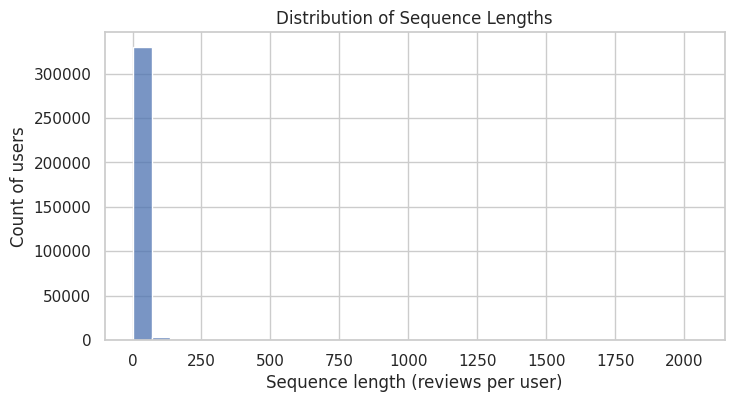

Average length: 12.58, median: 8


In [12]:
lengths = sequences.apply(len)
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(lengths, bins=30, ax=ax)
ax.set_title('Distribution of Sequence Lengths')
ax.set_xlabel('Sequence length (reviews per user)')
ax.set_ylabel('Count of users')
plt.show()

print(f"Average length: {lengths.mean():.2f}, median: {lengths.median():.0f}")


In [13]:
top_games = df_filtered['product_id'].value_counts().head(10)
top_games


product_id
440       68041
252490    43634
377160    36878
49520     34986
620       30420
319630    25312
391540    25279
221100    24208
271590    23793
230410    22743
Name: count, dtype: int64

## Identify the Predictive Task

We model sequential next-item prediction: given a user's ordered purchase/review history \(S_u = (i_1, \dots, i_t)\), predict the next game \(i_{t+1}\). We adopt leave-one-out evaluation:

- For each user sequence we reserve the last interaction as **test**, the penultimate as **validation**, and the rest for **training**.
- Metrics: **Hit@10** (Recall@10) and **NDCG@10** to capture ranking quality within the top 10 recommendations.
- Baselines: (1) MostPopular (PopRec), (2) First-order Markov Chain, (3) Item-KNN based on item co-occurrence.
- Validity guards: temporal ordering is preserved, and we evaluate only users with ≥5 interactions to mitigate cold-start noise.


In [14]:
train_histories, val_targets, test_targets = leave_one_out_split(sequences)
print(f"Prepared {len(train_histories)} user histories for training")
print(f"Validation targets: {len(val_targets)}, Test targets: {len(test_targets)}")

# For evaluation we only keep users with non-empty histories after splitting
common_users = set(train_histories.keys()) & set(test_targets.keys())
train_histories_eval = {u: train_histories[u] for u in common_users}
test_targets_eval = {u: test_targets[u] for u in common_users}
print(f"Users in eval set: {len(test_targets_eval)}")


Prepared 334725 user histories for training
Validation targets: 334725, Test targets: 334725
Users in eval set: 334725


In [15]:
%%time
pop_model = MostPopularRecommender().fit(train_histories_eval)
pop_hit, pop_ndcg = evaluate_model(pop_model, train_histories_eval, test_targets_eval, k=10)
print(f"MostPopular -> Hit@10: {pop_hit:.4f}, NDCG@10: {pop_ndcg:.4f}")


MostPopular -> Hit@10: 0.0618, NDCG@10: 0.0306
CPU times: user 5min 16s, sys: 8.54 s, total: 5min 25s
Wall time: 5min 31s


In [ ]:
%%time
mc_model = MarkovChainRecommender().fit(train_histories_eval)
mc_hit, mc_ndcg = evaluate_model(mc_model, train_histories_eval, test_targets_eval, k=10)
print(f"Markov Chain -> Hit@10: {mc_hit:.4f}, NDCG@10: {mc_ndcg:.4f}")


In [ ]:
%%time
knn_model = ItemKNNRecommender(top_neighbors=50).fit(train_histories_eval)
knn_hit, knn_ndcg = evaluate_model(knn_model, train_histories_eval, test_targets_eval, k=10)
print(f"Item-KNN -> Hit@10: {knn_hit:.4f}, NDCG@10: {knn_ndcg:.4f}")


In [ ]:
baseline_results = pd.DataFrame([
    {"Model": "MostPopular", "Hit@10": pop_hit, "NDCG@10": pop_ndcg},
    {"Model": "MarkovChain", "Hit@10": mc_hit, "NDCG@10": mc_ndcg},
    {"Model": "ItemKNN", "Hit@10": knn_hit, "NDCG@10": knn_ndcg},
])
baseline_results


In [ ]:
# save pretrained models
import joblib

# Save the pretrained models for reuse or later fine-tuning
joblib.dump(pop_model, "pretrained_models/pop_model.joblib")
joblib.dump(mc_model, "pretrained_models/mc_model.joblib")
joblib.dump(knn_model, "pretrained_models/knn_model.joblib")


### Notes on Validity
- **Temporal integrity**: Sorting by `date` ensures no future leakage.
- **Cold-start filtering**: Removing users/items with <5 interactions stabilizes evaluation.
- **Baselines** cover popularity, short-term transitions, and similarity-driven collaborative filtering, aligning with the proposal's comparison plan.


## Next Steps
With previous steps complete, the dataset is ready for training advanced sequential recommenders (e.g., SASRec). Future work will plug into the `train_histories` and evaluation utilities defined above.


## Modeling (SASRec)

We now move beyond baselines and implement a self-attentive sequential recommender (SASRec). The key steps are:

1. Encode item IDs to contiguous integers suitable for embedding layers.
2. Construct fixed-length sequences and targets for autoregressive next-item prediction.
3. Train a lightweight SASRec model on GPU.
4. Evaluate it on a held-out subset using the same Hit@10 / NDCG@10 metrics.


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MAX_SEQ_LEN = 50
MAX_TRAIN_SAMPLES = 400_000  # cap for manageable training
BATCH_SIZE = 256
EPOCHS = 3
HIDDEN_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 1e-3
EVAL_K = 10
EVAL_USERS = 20000  # sample for SASRec evaluation

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


In [ ]:
all_items = sorted(df_filtered['product_id'].unique())
item2idx = {item: idx + 1 for idx, item in enumerate(all_items)}  # 0 reserved for padding
idx2item = {idx: item for item, idx in item2idx.items()}
num_items = len(item2idx) + 1

print(f"Vocabulary size (including padding): {num_items}")

encoded_histories = {}
for user, seq in train_histories.items():
    encoded_seq = [item2idx[item] for item in seq if item in item2idx]
    if len(encoded_seq) >= 2:
        encoded_histories[user] = encoded_seq

len(encoded_histories)


In [ ]:
def build_training_samples(encoded_histories, max_len=50, max_records=None):
    sequences = []
    lengths = []
    targets = []
    for seq in encoded_histories.values():
        for idx in range(1, len(seq)):
            start = max(0, idx - max_len)
            hist = seq[start:idx]
            if not hist:
                continue
            padded = [0] * (max_len - len(hist)) + hist  # left-pad with zeros
            sequences.append(padded)
            lengths.append(min(len(hist), max_len))
            targets.append(seq[idx])
    if max_records and len(sequences) > max_records:
        idxs = list(range(len(sequences)))
        random.shuffle(idxs)
        idxs = idxs[:max_records]
        sequences = [sequences[i] for i in idxs]
        lengths = [lengths[i] for i in idxs]
        targets = [targets[i] for i in idxs]
    return np.array(sequences, dtype=np.int64), np.array(lengths, dtype=np.int64), np.array(targets, dtype=np.int64)

train_X, train_len, train_y = build_training_samples(encoded_histories, MAX_SEQ_LEN, MAX_TRAIN_SAMPLES)
train_X.shape


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, X, lengths, y):
        self.X = torch.from_numpy(X)
        self.lengths = torch.from_numpy(lengths)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.lengths[idx], self.y[idx]


def get_dataloader(X, lengths, y, batch_size, shuffle=True):
    dataset = SequenceDataset(X, lengths, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

train_loader = get_dataloader(train_X, train_len, train_y, BATCH_SIZE, shuffle=True)
len(train_loader)


In [ ]:
class SASRec(nn.Module):
    def __init__(self, num_items, hidden_dim, max_len, num_heads, num_layers, dropout):
        super().__init__()
        self.item_emb = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)
        self.output = nn.Linear(hidden_dim, num_items)
        self.max_len = max_len

    def forward(self, seqs, lengths):
        batch_size, seq_len = seqs.size()
        positions = torch.arange(seq_len, device=seqs.device).unsqueeze(0).expand(batch_size, -1)
        x = self.item_emb(seqs) + self.pos_emb(positions)
        x = self.layernorm(self.dropout(x))

        attn_mask = torch.triu(torch.ones((seq_len, seq_len), device=seqs.device), diagonal=1).bool()
        pad_mask = seqs.eq(0)
        encoded = self.encoder(x, mask=attn_mask, src_key_padding_mask=pad_mask)

        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(-1, 1, encoded.size(-1))
        last_hidden = encoded.gather(1, idx).squeeze(1)
        logits = self.output(last_hidden)
        return logits


In [ ]:
%%time
sasrec = SASRec(
    num_items=num_items,
    hidden_dim=HIDDEN_DIM,
    max_len=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sasrec.parameters(), lr=LR)

sasrec.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    for batch_seqs, batch_len, batch_targets in train_loader:
        batch_seqs = batch_seqs.to(DEVICE)
        batch_len = batch_len.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)

        optimizer.zero_grad()
        logits = sasrec(batch_seqs, batch_len)
        loss = criterion(logits, batch_targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_seqs.size(0)
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")


In [ ]:
def prepare_eval_tensors(users, histories, max_len):
    seqs = []
    lengths = []
    valid_users = []
    for user in users:
        hist = histories.get(user)
        if not hist:
            continue
        encoded = [item2idx[item] for item in hist if item in item2idx]
        if not encoded:
            continue
        hist_slice = encoded[-max_len:]
        padded = [0] * (max_len - len(hist_slice)) + hist_slice
        seqs.append(padded)
        lengths.append(min(len(hist_slice), max_len))
        valid_users.append(user)
    if not seqs:
        return None, None, []
    seqs = torch.tensor(seqs, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return seqs, lengths, valid_users


def recommend_sasrec(model, users, histories, top_k=10, batch_size=1024):
    model.eval()
    rankings = {}
    with torch.no_grad():
        for i in range(0, len(users), batch_size):
            batch_users = users[i:i + batch_size]
            seqs, lengths, valid_users = prepare_eval_tensors(batch_users, histories, MAX_SEQ_LEN)
            if not valid_users:
                continue
            seqs = seqs.to(DEVICE)
            lengths = lengths.to(DEVICE)
            logits = model(seqs, lengths)
            logits = logits.clone()
            for row_idx, user in enumerate(valid_users):
                seen = {item2idx[item] for item in histories[user] if item in item2idx}
                logits[row_idx, list(seen)] = -1e9
            topk = torch.topk(logits, top_k, dim=1).indices.cpu().numpy()
            for user, rec_idx in zip(valid_users, topk):
                rankings[user] = [idx2item[idx] for idx in rec_idx if idx in idx2item]
    return rankings


In [ ]:
sample_users = random.sample(list(test_targets_eval.keys()), min(EVAL_USERS, len(test_targets_eval)))
sub_histories = {u: train_histories_eval[u] for u in sample_users}
sub_targets = {u: test_targets_eval[u] for u in sample_users}

sasrec_rankings = recommend_sasrec(sasrec, sample_users, sub_histories, top_k=EVAL_K)

sas_hit = hit_rate_at_k(sasrec_rankings, sub_targets, k=EVAL_K)
sas_ndcg = ndcg_at_k(sasrec_rankings, sub_targets, k=EVAL_K)
print(f"SASRec (sample {len(sample_users)} users) -> Hit@{EVAL_K}: {sas_hit:.4f}, NDCG@{EVAL_K}: {sas_ndcg:.4f}")


In [ ]:
comparison_results = baseline_results.copy()
comparison_results = pd.concat([
    comparison_results,
    pd.DataFrame([{"Model": f"SASRec (sample {len(sample_users)})", "Hit@10": sas_hit, "NDCG@10": sas_ndcg}])
], ignore_index=True)
comparison_results
